### Ethnicolr: NC Voter Registration Name Model (Race only)

We build a separate model that only predicts the race_code and takes out 'U', again assuming it to be 'missing at random.'

In [1]:
import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)

2021-12-21 16:32:12.628571: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-21 16:32:12.628624: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.5.0
2.5.2


In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [3]:
NGRAMS = (2, 3)
SAMPLE = 1000000
EPOCHS = 15

# NC voter
df = pd.read_csv('/opt/data/nc_voter/nc_voter_name_gender_race_ethnic_age.csv.gz', usecols=['last_name', 'first_name', 'race_code'], nrows=SAMPLE * 2)
df.dropna(subset=['first_name', 'last_name'], inplace=True)

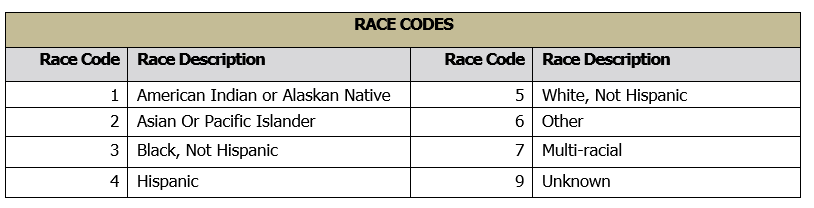

### Drop U and UN from race and ethnic.

In [4]:
df.drop(df[df.race_code=='U'].index, inplace=True)
df

,last_name,first_name,race_code
0,AABEL,EVELYN,W
1,AARON,CHRISTINA,W
2,AARON,CLAUDIA,W
3,AARON,JAMES,W
4,AARON,NATHAN,W
...,...,...,...
1999995,LEAK,ANTHONY,B
1999996,LEAK,ANTOINETTE,B
1999997,LEAK,BETTY,B
1999998,LEAK,BILLY,B


In [5]:
df.groupby(['race_code']).size()

race_code
A      16176
B     376291
I       7761
M      12004
O      41580
W    1482050
dtype: int64

In [6]:
df['race'] = df['race_code']
df

,last_name,first_name,race_code,race
0,AABEL,EVELYN,W,W
1,AARON,CHRISTINA,W,W
2,AARON,CLAUDIA,W,W
3,AARON,JAMES,W,W
4,AARON,NATHAN,W,W
...,...,...,...,...
1999995,LEAK,ANTHONY,B,B
1999996,LEAK,ANTOINETTE,B,B
1999997,LEAK,BETTY,B,B
1999998,LEAK,BILLY,B,B


In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.groupby(['race']).size()

race
A     15262
B    293173
I      7356
M     11844
O     39305
W    991209
dtype: int64

In [9]:
max_size = df['race'].value_counts().max()
lst = [df]
for class_index, group in df.groupby('race'):
    lst.append(group.sample(max_size-len(group), replace=True))
odf = pd.concat(lst)
odf

,last_name,first_name,race_code,race
0,AABEL,EVELYN,W,W
1,AARON,CHRISTINA,W,W
2,AARON,CLAUDIA,W,W
3,AARON,JAMES,W,W
4,AARON,NATHAN,W,W
...,...,...,...,...
1235311,PEREZ,ELISA,O,O
787168,ROJEK,SABRINA,O,O
1978089,IANNELLO,KELLY,O,O
1001323,GODOY DIEGO,LUIS,O,O


In [10]:
odf.groupby('race').agg({'first_name': 'count'})

,first_name
race,
A,991209
B,991209
I,991209
M,991209
O,991209
W,991209


In [11]:
sdf = odf.sample(SAMPLE, random_state=21)
sdf

,last_name,first_name,race_code,race
1314558,CREIGHTON,BONITA,B,B
751954,LEE,CHEE,A,A
1877347,BAKER,CHRISTAIN,W,W
1905838,CATES,JEAN,B,B
1980964,JANARDHAN,SHEILA,A,A
...,...,...,...,...
1518449,MATTOCK,DAVID PAUL,O,O
639827,HUFFMAN,ABIGAIL,A,A
1099368,GHOSH,ABHA,I,I
1908877,CHOI,STEVE,A,A


In [12]:
# Additional features
sdf['first_name'] = sdf.first_name.str.title()
sdf['last_name'] = sdf.last_name.str.title()

rdf = sdf.groupby('race').agg({'first_name': 'count'})
rdf

,first_name
race,
A,166890
B,166431
I,166462
M,166516
O,166334
W,167367


In [13]:
rdf.to_csv('./nc_voter_reg/lstm/nc_name_race_only.csv', columns=[])

## Preprocessing the input data

In [14]:
%%time
# concat last name and first name
sdf['last_name_first_name'] = sdf['last_name'] + ' ' + sdf['first_name']

# build n-gram list
vect = CountVectorizer(analyzer='char', max_df=0.3, min_df=10, ngram_range=NGRAMS, lowercase=False) 
a = vect.fit_transform(sdf.last_name_first_name)
vocab = vect.vocabulary_

# sort n-gram by freq (highest -> lowest)
words = []
for b in vocab:
    c = vocab[b]
    #print(b, c, a[:, c].sum())
    words.append((a[:, c].sum(), b))
    #break
words = sorted(words, reverse=True)
words_list = ['UNK']
words_list.extend([w[1] for w in words])
num_words = len(words_list)
print("num_words = %d" % num_words)

num_words = 12896
CPU times: user 26min 43s, sys: 1.66 s, total: 26min 44s
Wall time: 27min 13s


In [15]:
vocab

{'Cr': 1254,
 're': 10389,
 'ei': 6209,
 'ig': 7568,
 'gh': 6869,
 'ht': 7322,
 'to': 11289,
 'on': 9756,
 'n ': 9011,
 ' B': 31,
 'Bo': 1088,
 'ni': 9217,
 'it': 7808,
 'ta': 11126,
 'Cre': 1256,
 'rei': 10401,
 'eig': 6218,
 'igh': 7577,
 'ght': 6883,
 'hto': 7333,
 'ton': 11305,
 'on ': 9757,
 'n B': 9013,
 ' Bo': 38,
 'Bon': 1101,
 'oni': 9768,
 'nit': 9238,
 'ita': 7811,
 'Le': 2632,
 'ee': 6127,
 'e ': 5990,
 ' C': 43,
 'Ch': 1194,
 'he': 7149,
 'Lee': 2639,
 'ee ': 6128,
 'e C': 5993,
 ' Ch': 46,
 'Che': 1196,
 'hee': 7156,
 'Ba': 998,
 'ak': 4826,
 'ke': 8129,
 'er': 6383,
 'r ': 10264,
 'hr': 7299,
 'ri': 10451,
 'is': 7784,
 'st': 11008,
 'ai': 4779,
 'in': 7685,
 'Bak': 1010,
 'ake': 4831,
 'ker': 8146,
 'er ': 6384,
 'r C': 10267,
 'Chr': 1202,
 'hri': 7304,
 'ris': 10472,
 'ist': 7802,
 'sta': 11011,
 'tai': 11137,
 'ain': 4795,
 'Ca': 1155,
 'at': 5041,
 'te': 11169,
 'es': 6410,
 's ': 10724,
 ' J': 154,
 'Je': 2310,
 'ea': 6046,
 'an': 4901,
 'Cat': 1173,
 'ate': 5047,


In [16]:
from itertools import chain

def n_grams(seq, n=1):
    """Returns an itirator over the n-grams given a listTokens"""
    shiftToken = lambda i: (el for j,el in enumerate(seq) if j>=i)
    shiftedTokens = (shiftToken(i) for i in range(n))
    tupleNGrams = zip(*shiftedTokens)
    return tupleNGrams # if join in generator : (" ".join(i) for i in tupleNGrams)

def range_ngrams(listTokens, ngramRange=(1,2)):
    """Returns an itirator over all n-grams for n in range(ngramRange) given a listTokens."""
    ngrams = (ngramRange[0], ngramRange[1] + 1)
    return chain(*(n_grams(listTokens, i) for i in range(*ngramRange)))

In [17]:
%%time
def find_ngrams(text, ngrams):
    a = range_ngrams(text, ngrams)
    wi = []
    for i in a:
        w = ''.join(i)
        try:
            idx = words_list.index(w)
        except:
            idx = 0
        wi.append(idx)
    return wi

# build X from index of n-gram sequence
X = np.array(sdf.last_name_first_name.apply(lambda c: find_ngrams(c, NGRAMS)))

# check max/avg feature
X_len = []
for x in X:
    X_len.append(len(x))

max_feature_len = max(X_len)
avg_feature_len = int(np.mean(X_len))

print("Max feature len = %d, Avg. feature len = %d" % (max_feature_len, avg_feature_len))
y = np.array(sdf.race.astype('category').cat.codes)

# Split train and test dataset
X_train,  X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)

Max feature len = 37, Avg. feature len = 12
CPU times: user 1min 39s, sys: 779 ms, total: 1min 40s
Wall time: 1min 45s


## Train a LSTM model

ref: http://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [18]:
'''The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
Notes:

- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.

- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Activation
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.models import load_model

max_features = num_words # 20000
feature_len = 25 # avg_feature_len # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print('Pad sequences (samples x time)')
X_train = sequence.pad_sequences(X_train, maxlen=feature_len)
X_test = sequence.pad_sequences(X_test, maxlen=feature_len)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

800000 train sequences
200000 test sequences
Pad sequences (samples x time)
X_train shape: (800000, 25)
X_test shape: (200000, 25)
6 classes
Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (800000, 6)
y_test shape: (200000, 6)


In [19]:
print('Build model...')

if False:
    model = Sequential()
    model.add(Embedding(num_words, 32, input_length=feature_len))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
if True:
    embedding_vecor_length = 50
    model = Sequential()
    model.add(Embedding(num_words, embedding_vecor_length, input_length=feature_len))
    model.add(Conv1D(activation="relu", padding="same", filters=32, kernel_size=3))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100))
    model.add(Dense(num_classes, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Build model...


2021-12-21 17:01:30.878300: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-21 17:01:30.880214: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-21 17:01:30.880251: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-server-2): /proc/driver/nvidia/version does not exist
2021-12-21 17:01:30.880532: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 50)            644800    
_________________________________________________________________
conv1d (Conv1D)              (None, 25, 32)            4832      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 6)                 606       
Total params: 703,438
Trainable params: 703,438
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
%%time
print('Train...')
model.fit(X_train, y_train, batch_size=batch_size, epochs=EPOCHS,
          validation_split=0.1, verbose=1)
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size, verbose=1)
print('Test score:', score)
print('Test accuracy:', acc)

Train...


2021-12-21 17:01:31.813311: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-21 17:01:31.814342: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2250000000 Hz


Epoch 1/15
22500/22500 [==============================] - 489s 20ms/step - loss: 1.4239 - accuracy: 0.4304 - val_loss: 1.2435 - val_accuracy: 0.5150
Epoch 2/15
22500/22500 [==============================] - 460s 20ms/step - loss: 1.1839 - accuracy: 0.5426 - val_loss: 1.0585 - val_accuracy: 0.5979
Epoch 3/15
22500/22500 [==============================] - 461s 20ms/step - loss: 0.9949 - accuracy: 0.6229 - val_loss: 0.9367 - val_accuracy: 0.6456
Epoch 4/15
22500/22500 [==============================] - 457s 20ms/step - loss: 0.8736 - accuracy: 0.6719 - val_loss: 0.8758 - val_accuracy: 0.6720
Epoch 5/15
22500/22500 [==============================] - 451s 20ms/step - loss: 0.8082 - accuracy: 0.6969 - val_loss: 0.8260 - val_accuracy: 0.6904
Epoch 6/15
22500/22500 [==============================] - 369s 16ms/step - loss: 0.7672 - accuracy: 0.7112 - val_loss: 0.8117 - val_accuracy: 0.6950
Epoch 7/15
22500/22500 [==============================] - 363s 16ms/step - loss: 0.7454 - accuracy: 0.7197

In [21]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.7509689331054688
Test accuracy: 0.7183650135993958


## Confusion Matrix

In [22]:
p = model.predict(X_test, verbose=2) # to predict probability
y_pred = np.argmax(p, axis=-1)
target_names = list(sdf.race.astype('category').cat.categories)
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names))

6250/6250 - 24s
              precision    recall  f1-score   support

           A       0.84      0.89      0.86     33378
           B       0.57      0.54      0.56     33286
           I       0.85      0.94      0.89     33292
           M       0.76      0.81      0.78     33303
           O       0.75      0.57      0.65     33267
           W       0.53      0.55      0.54     33474

    accuracy                           0.72    200000
   macro avg       0.72      0.72      0.71    200000
weighted avg       0.72      0.72      0.71    200000



In [23]:
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(conf_mat)

[[29691   716   211   306  1260  1194]
 [  948 18035  1946  3317  1398  7642]
 [  158   677 31225   287   239   706]
 [  262  2186   471 27126  1279  1979]
 [ 3042  3468   713  1816 19051  5177]
 [ 1436  6313  1976  3026  2178 18545]]


In [26]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

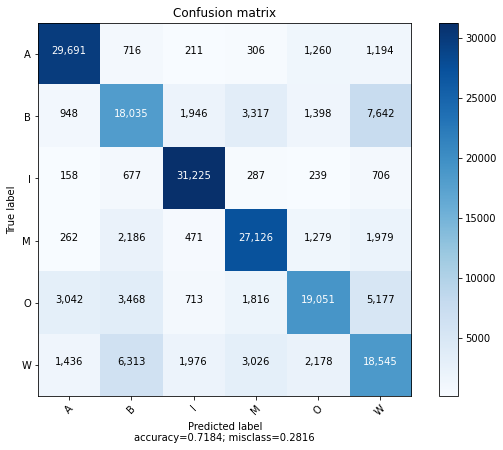

In [27]:
plot_confusion_matrix(conf_mat, target_names, normalize=False)

### Save model

In [28]:
model.save('./nc_voter_reg/lstm/nc_voter_name_race_lstm_oversample.h5')

In [29]:
words_df = pd.DataFrame(words_list, columns=['vocab'])
words_df.to_csv('./nc_voter_reg/lstm/nc_voter_name_race_vocab_oversample.csv', index=False, encoding='utf-8')